In [2]:
import sys
sys.path.insert(0, '/home/ejafari/alignment/Git/src/')
from utils import *
from AIscEA import *
from evals import *
from rmCls import *
from similarity import *
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# Clusterign RNA and ATAC

AnnData object with n_obs × n_vars = 36601 × 2711
AnnData object with n_obs × n_vars = 2711 × 36601
2711
36601


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
2711
21256
View of AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
View of AnnData object with n_obs × n_vars = 2711 × 3774
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


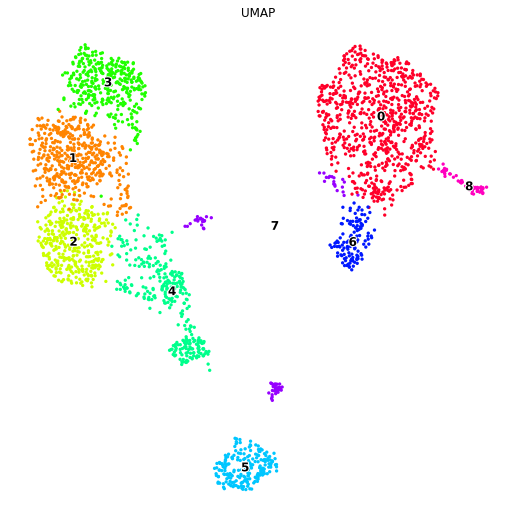

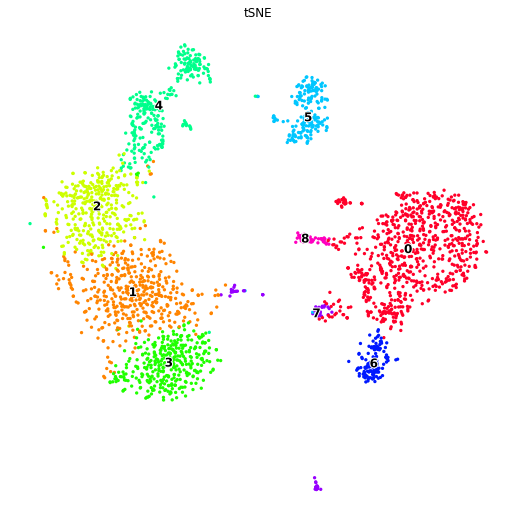

0 : 764
1 : 463
2 : 370
3 : 355
4 : 316
5 : 201
6 : 119
7 : 72
8 : 51


In [3]:
############################ High_var = True ######################################
input_dir = "/home/ejafari/alignment/downstream/data/PBMC_3k/mine/rna.csv"
# scRNAseq_adrs = input_dir + 'scRNAseq.csv'
# Find marker genes of scRNAseq data
markers_rna, rna = scRNAseq_clustering_original(input_dir, filtering=True, resl=0.3, highly_var=True , tr=True, n_pc=15) 

# 20 neigh (dfault) cosine 15 PCs

AnnData object with n_obs × n_vars = 6 × 2711
AnnData object with n_obs × n_vars = 2711 × 6


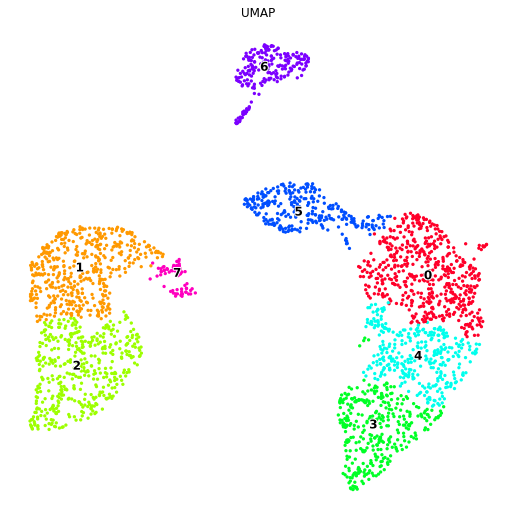

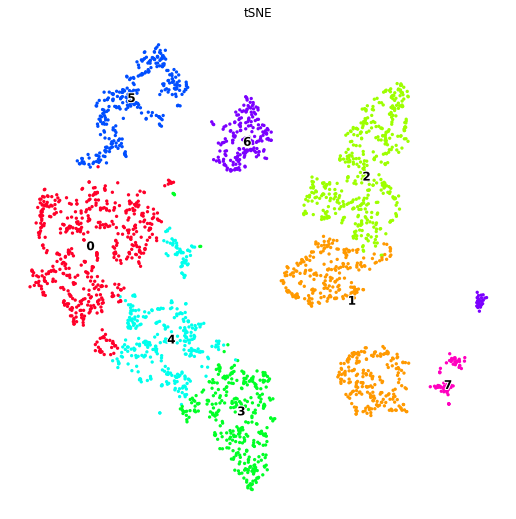

0 : 541
1 : 458
2 : 439
3 : 348
4 : 342
5 : 294
6 : 221
7 : 68


In [4]:
# Find clusters of low dimensional cisTopic result for scATACseq

input_dir = "/home/ejafari/alignment/downstream/data/PBMC_3k/mine/"
atac = clustering(input_dir + 'atac_topics.tsv', transpose=True, resl=0.22) 


############################ scATAC ######################################
# 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
input_dir = "/home/ejafari/alignment/downstream/data/PBMC_3k/mine/"
f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)


# To match pattern names of the cells in RNA and ATAC data
atac_cis_on_org.obs.index = [i.replace('.','-') for i in atac_cis_on_org.obs.index] 

# Cell-type mapping¶

In [5]:
rna, atac_cis_on_org,  markers_rna, markers_atac = rm_tiny_cluster(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

RNA: 8
RNA: 6
RNA: 7
ATAC: 7


In [6]:
col_ind, rna, atac_cis_on_org = extract_mapped_clusters(rna, markers_rna, atac_cis_on_org, markers_atac, p_val_count=6)

0.0
0.0 [1 4 0 3 5 6]
[1 4 0 3 5 6]
P-value:  {(5, 6): 0.0, (2, 0): 0.0, (1, 4): 0.0050000000000000044, (0, 1): 0.0, (3, 3): 0.0, (4, 5): 0.0}
$$$$$$$ 
 
0.1
0.1 [2 4 0 3 5 6]
[2 4 0 3 5 6]
P-value:  {(5, 6): 0.0, (2, 0): 0.0, (1, 4): 0.007000000000000006, (0, 2): 0.0, (3, 3): 0.03600000000000003, (4, 5): 0.0}
$$$$$$$ 
 
0.2
0.2 [2 3 0 4 5 6]
[2 3 0 4 5 6]
P-value:  {(5, 6): 0.0, (2, 0): 0.0, (1, 3): 0.009000000000000008, (0, 2): 0.0, (3, 4): 0.0, (4, 5): 0.0}
$$$$$$$ 
 
0.30000000000000004
0.3 [1 3 0 4 5 6]
[1 3 0 4 5 6]
P-value:  {(2, 0): 0.0, (5, 6): 0.0, (1, 3): 0.0, (3, 4): 0.006000000000000005, (0, 1): 0.0, (4, 5): 0.0}
$$$$$$$ 
 
0.4
0.4 [2 3 0 4 5 6]
[2 3 0 4 5 6]
P-value:  {(2, 0): 0.0, (5, 6): 0.0, (1, 3): 0.0, (3, 4): 0.015000000000000013, (4, 5): 0.0, (0, 2): 0.0}
$$$$$$$ 
 
0.5
0.5 [2 4 3 0 5 6]
[2 4 3 0 5 6]
P-value:  {(2, 3): 0.0, (1, 4): 0.0020000000000000018, (5, 6): 0.0, (3, 0): 0.010000000000000009, (4, 5): 0.0, (0, 2): 0.0}
$$$$$$$ 
 
0.6000000000000001
0.6 [2 3 0 4

,0,1,2,3,4,5,6
0,0.0,3.0,7.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,5.0,4.0,0.0,0.0
2,7.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,10.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,10.0



Mapped clusters between Domain1 and Domain2:  {0: 2, 2: 0, 4: 5, 5: 6}

Removing non-significant clusters.


In [7]:
print(rna.shape, atac_cis_on_org.shape)


# Number of shared cells
len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))

(1651, 3774) (1495, 18079)


1171

# Cell-cell alignment in AIscEA¶

In [8]:
aligns_dict = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)

0
2718 1082
68081 18079
0 2
After combining multi-cells:  (439, 971)
2 0
After combining multi-cells:  (370, 17792)
4 5
After combining multi-cells:  (294, 558)
5 6
After combining multi-cells:  (201, 14611)
------------------------after RNA-ATAC similarity----------------------
------------------------before FW----------------------
Inside calc_foscttm: 
363
Check:  764 439 2
Inside calc_foscttm, adata_atac_k: 
764 439 363 0.13483930211202938 363 0.21088913814107907 0.17286422012655422
Inside calc_foscttm: 
296
Check:  370 541 0
Inside calc_foscttm, adata_atac_k: 
370 541 298 0.15960175581316519 333 0.14080948418297815 0.15020561999807167
Inside calc_foscttm: 
284
Check:  316 294 5
Inside calc_foscttm, adata_atac_k: 
316 294 311 0.10905583162817889 286 0.10467778540067697 0.10686680851442792
Inside calc_foscttm: 
188
Check:  201 221 6
Inside calc_foscttm, adata_atac_k: 
201 221 199 0.06171437998071163 189 0.06743375618877627 0.06457406808474395
lambda, lev, n_neigh, n_iter, FOSCTTM1, 

# Cluster mapping overlap coefficient

In [11]:
# Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common


,a_0,a_2,a_5,a_6
r_0,0.0,363.0,0.0,0.0
r_2,296.0,0.0,2.0,0.0
r_4,26.0,0.0,284.0,1.0
r_5,11.0,0.0,0.0,188.0


In [13]:
# Double check the true mappings using cell labels
import pickle
import pandas as pd
df_cells_common = pd.DataFrame(columns=['overlap', 'union', 'jacc', 'overlap/min'])
out_dir = "/home/ejafari/alignment/downstream/notebooks/FW_cluster_cell_names/Mus_5k/"
cls_overlap_dict = dict()

for cls_rna in sorted(set(rna.obs['leiden'])):
    cls_atac = str(col_ind[int(cls_rna)])
    cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
    cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
    overlap = set(cells_atac) & set(cells_rna)
    n_overlapping = len(overlap)
    cls_overlap_dict[cls_rna + "_" + cls_atac] = overlap
    

        
    n_union = len(set(cells_rna).union(cells_atac))
    jacc = n_overlapping/n_union
    overlap_min = n_overlapping/min(len(cells_rna), len(cells_atac))
    df_cells_common.loc['r_' + str(cls_rna) + '_a_' + str(cls_atac)] = [n_overlapping, n_union, jacc, overlap_min]

    print(cls_rna, cls_atac, len(cells_rna), len(cells_atac), n_union, n_overlapping, jacc) 
    
    # Save overlapping cell names in mapped clusters
with open(out_dir + 'overlap_mapped_clusters.pickle', 'wb') as handle:
    pickle.dump(cls_overlap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
df_cells_common



0 2 764 439 840 363 0.43214285714285716
2 0 370 541 615 296 0.4813008130081301
4 5 316 294 326 284 0.8711656441717791
5 6 201 221 234 188 0.8034188034188035


,overlap,union,jacc,overlap/min
r_0_a_2,363.0,840.0,0.432143,0.826879
r_2_a_0,296.0,615.0,0.481301,0.800000
r_4_a_5,284.0,326.0,0.871166,0.965986
r_5_a_6,188.0,234.0,0.803419,0.935323


In [20]:
# sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='UMAP ATACseq', palette='gist_rainbow', save='UMAP_ATAC_3k_selected.svg')#
# sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='UMAP RNAseq', palette='gist_rainbow', save='UMAP_RNA_3k_selected.svg')#